# Filter fragments for synthesizability

## Aim of this notebook

This notebook is filtering the fragments for synthesizability.
* The first filter checks the availability of similar buyable building blocks in the [Enamine REAL Space](https://enamine.net/compound-collections/real-compounds/real-space-navigator) to ensure that the resulting molecules can easily be synthesized.
* The second filter calculates the SYnthetic Bayesian Accessibility ([SYBA](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2)), which estimates whether a fragment is more likely to be easy or hard to synthesize.

## Table of contents
1. Load fragment library
2. Apply pre-filters
3. Filter for buyable building blocks

    3.1. Data preparation
    
    3.2. Filter fragments for buyable building blocks
4. Filter for SYnthetic Bayesian Accessibility (SYBA)
5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)

    5.2. Histogram of SYBA values

## Imports and preprocessing

In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

from kinfraglib import utils, filters

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Globals

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"
PATH_DATA_ENAMINE = HERE / "../../data/filters/DataWarrior"

## 1. Load fragment library

Fragment library is stored as a dictionary, with the individual subpockets as keys.

In [5]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [6]:
fragment_library_original.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library_original).reset_index(drop=True).shape

(7486, 15)

## 2. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library = filters.prefilters.pre_filters(fragment_library_original)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

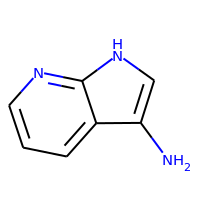
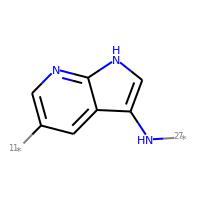
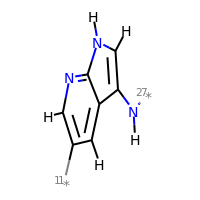
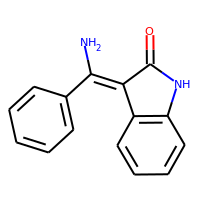
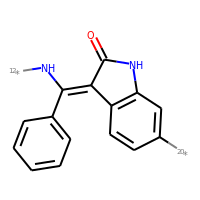
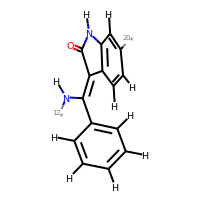
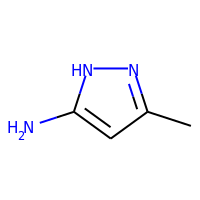
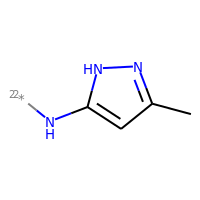
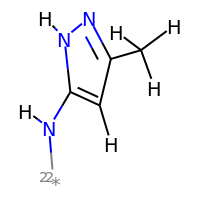
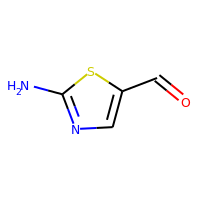
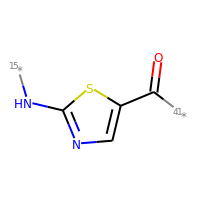
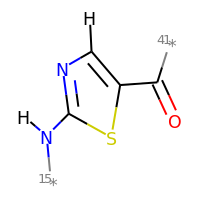
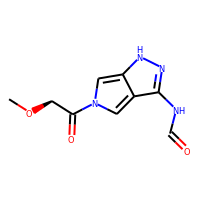
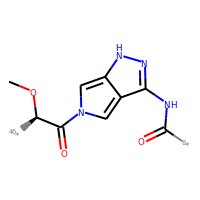
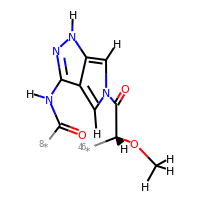

In [9]:
fragment_library["AP"].head()

Count number of fragments in the original fragment library and after pre-filtering the fragment library.

In [10]:
num_fragments = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library_original, "original"),
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
    ],
    axis=1,
)
num_fragments.append(num_fragments.sum().rename('Total'))

,original,pre_filtered
subpocket,,
AP,2561,1001
FP,1866,864
SE,1560,607
GA,1024,306
B1,98,42
B2,92,42
Total,7201,2862


## 3. Filter for buyable building blocks
The [Enamine REAL Space](https://enamine.net/compound-collections/real-compounds/real-space-navigator) contains over 19 billion building blocks that can be used to create compounds which can be synthesized on demand. [DataWarrior](https://openmolecules.org/datawarrior/index.html) is an open source software which can be used for searching building blocks in this huge chemical space.

In [11]:
?filters.building_blocks.check_building_blocks

Signature:
filters.building_blocks.check_building_blocks(
    fragment_library,
    path_to_building_blocks,
)
Docstring:
Read in Enamine Building Blocks from SDFile created with DataWarrior and check if the fragment
molecules are a substructure of building block molecules.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
path_to_building_blocks : str
    path to SDFile with resulting building blocks from DataWarrior is saved

Returns
-------
dict
    Containing a pandas.DataFrame for each subpocket with all fragments and an
    additional columns (bool_bb) defining whether the fragment is accepted (1), meaning found
    as a substructure in a building block, or rejected (0).
File:      ~/masterthesis/KinFragLib/kinfraglib/filters/building_blocks.py
Type:      function


**Note**: A description to the generation of the `"/filters/DataWarrior/Enamine_Building_Blocks.sdf"` file used in this function can be found in the [README](https://github.com/sonjaleo/KinFragLib/blob/review-update/data/filters/DataWarrior/README.md) file in the `"data/filters/DataWarrior"` directory.

In [12]:
fragment_library = filters.building_blocks.check_building_blocks(
    fragment_library,
    str(str(PATH_DATA_ENAMINE) + "/Enamine_Building_Blocks.sdf"),
)

Inspect individual subpockets, including the new column if similar building block found in ENAMINE (`bool_bb`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0

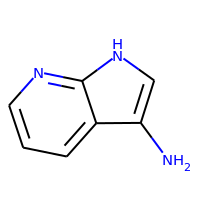
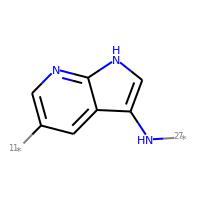
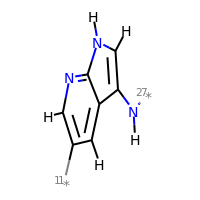
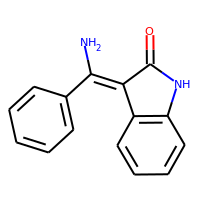
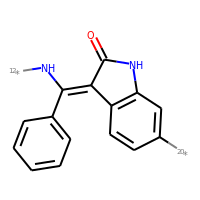
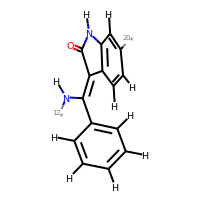
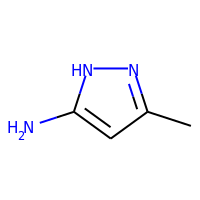
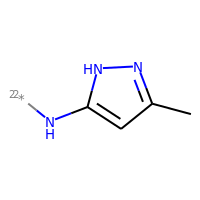
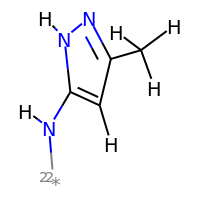
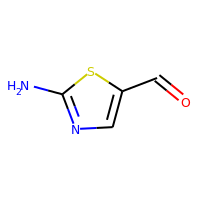
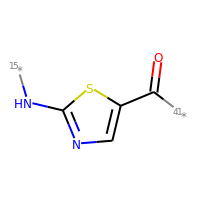
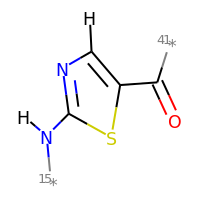
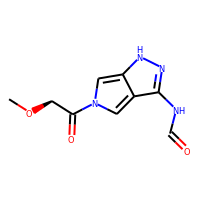
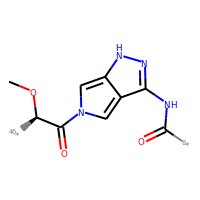
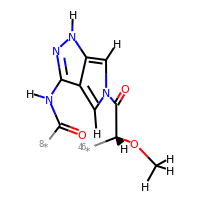

In [13]:
fragment_library["AP"].head()

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the Building Block filter.

In [14]:
num_fragments_bb = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_bb", "enamine"
        ),
    ],
    axis=1,
)
num_fragments_bb.append(num_fragments_bb.sum().rename('Total'))

,pre_filtered,accepted_enamine,rejected_enamine
subpocket,,,
AP,1001,346,655
FP,864,414,450
SE,607,332,275
GA,306,244,62
B1,42,38,4
B2,42,39,3
Total,2862,1413,1449


## 4. Filter for SYnthetic Bayesian Accessibility (SYBA)

The SYnthtetic Bayesian Accessibility Score [SYBA](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2) is a Bayesian probabilistic modeling method ([SYBA github repo](https://github.com/lich-uct/syba)) for calculating a fragment-based score using the frequency of fragments in easy- and hard-to-synthesizable molecules. 

A more negative score indicates a molecule which is more likely hard to synthesize, and a more positive score indicates a molecule which is more likely easy to synthesize.

In [15]:
?filters.syba.calc_syba

Signature:
filters.syba.calc_syba(
    fragment_library,
    cutoff=0,
    cutoff_criteria='>',
    query_type='mol',
)
Docstring:
Calculate the SYnthetic Bayesian Accessibility (SYBA) for each fragment and add a boolean
column if the fragment is accepted for the defined cutoff or not and a column with the
calculated SYBA values.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
cutoff : int
    defining the cutoff value for rejecting/accepting fragments. By , cutoff=0
cutoff_criteria : str
    defining if the fragment values need to be ">", "<", ">=", "<=", "==" or "!=" compared to
    the cutoff_value. By default, cutoff_criteria=">"
query_type : str
    "mol" or "smiles". Defining if the SYBA score gets predicted using the ROMol from the
    fragment library or the SMILES string. By default, query_type = "mol".

Returns
dict
    Containing a pandas.DataFrame for each subpocket with all fragments and an
    additional colum

In [16]:
fragment_library = filters.syba.calc_syba(fragment_library, cutoff=0)

Inspect individual subpockets, including the new column if SYBA score threshold fulfilled (`bool_syba`) and calculated SYBA score (`syba`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb,bool_syba,syba
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,30.950959
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0,1,17.682659
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,...,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,1,15.727015
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,...,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,1,12.789242
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,...,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,1,14.653939

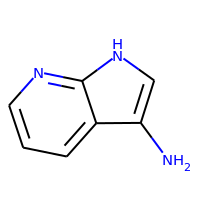
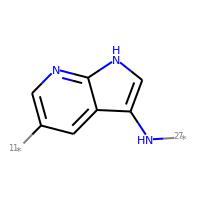
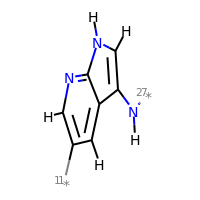
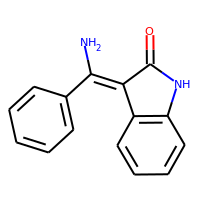
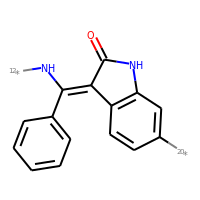
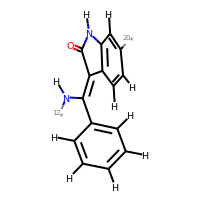
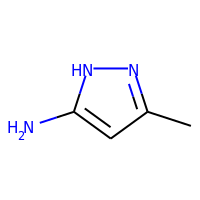
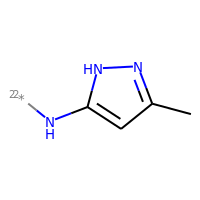
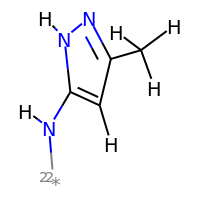
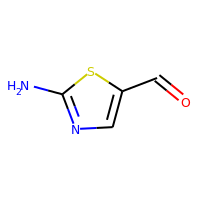
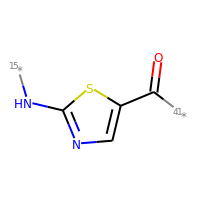
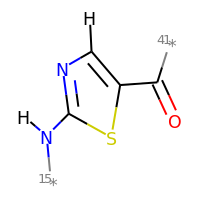
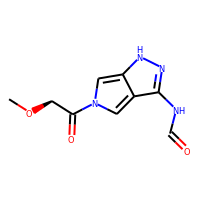
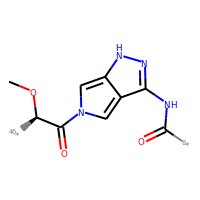
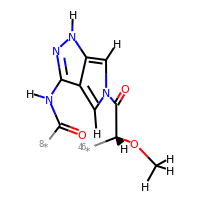

In [17]:
fragment_library["AP"].head()

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the SYBA filter.

In [18]:
num_fragments_syba = pd.concat(
    [
        filters.analysis.count_fragments(
            fragment_library, "pre_filtered"
        ),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_syba", "syba"
        ),
    ],
    axis=1,
)
num_fragments_syba.append(num_fragments_syba.sum().rename('Total'))

,pre_filtered,accepted_syba,rejected_syba
subpocket,,,
AP,1001,898,103
FP,864,689,175
SE,607,551,56
GA,306,280,26
B1,42,32,10
B2,42,39,3
Total,2862,2489,373


## 5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)

    5.2. Histogram of SYBA values

### 5.1. Count number of fragments that are accepted by the filter(s)

In [19]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=["bool_syba", "bool_bb"], min_accepted=2
)

In [20]:
filters.analysis.accepted_num_filters(fragment_library, ["bool_syba", "bool_bb"], filtername = "synthesizability filters", max_num_accepted = 2)

,pre-filtered,accepted by 2,accepted by 1,accepted by 0
AP,1001,337,570,94
FP,864,339,425,100
SE,607,293,297,17
GA,306,227,70,9
B1,42,28,14,0
B2,42,36,6,0
Total,2862,1260,1382,220


### 5.2. Histogram of SYBA values
Create a histogram for each subpocket showing the SYBA values.

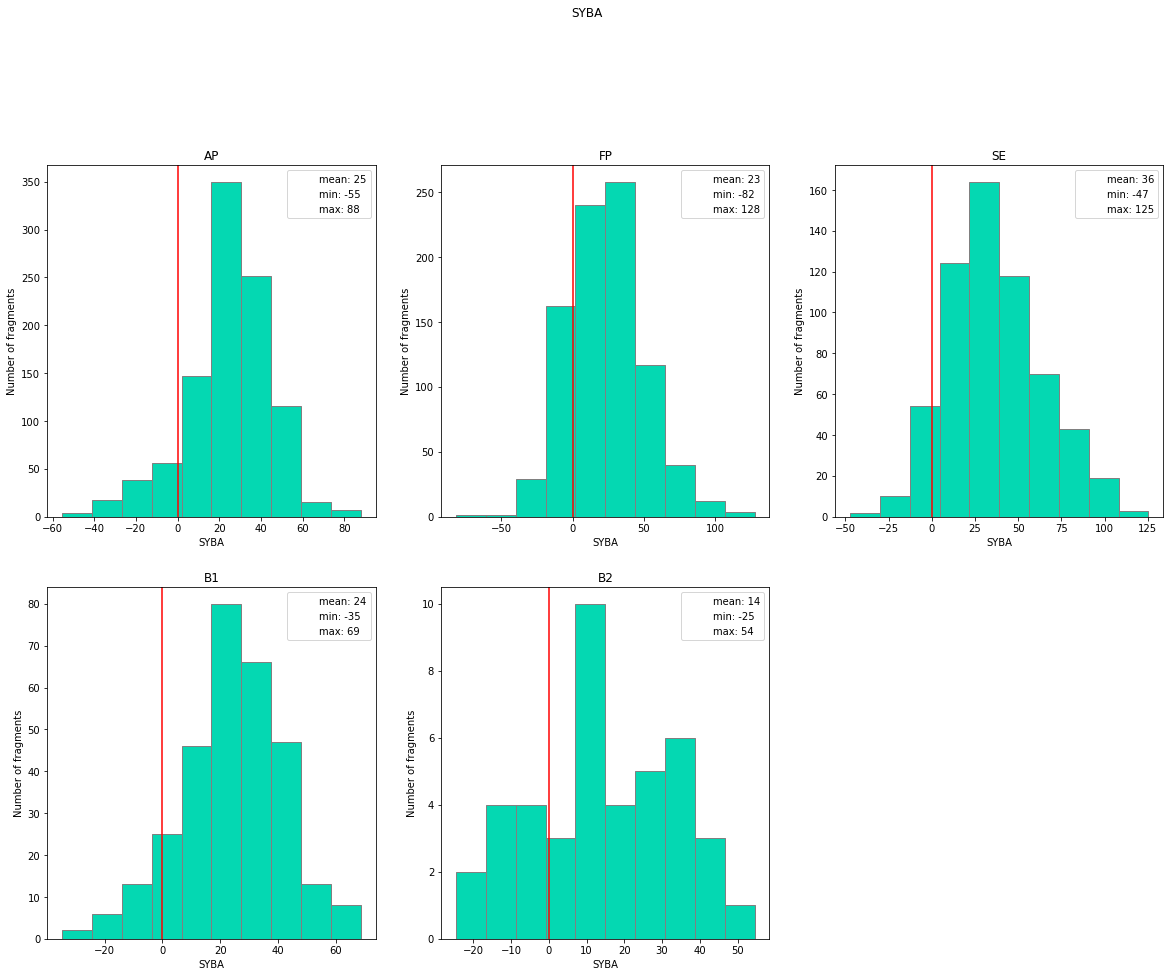

In [21]:
filters.plots.make_hists(
   fragment_library, colname="syba", filtername = "SYBA", plot_stats=True, cutoff=0
)

Todo: more analysis